# Mining of Alexa interactions and smart home data 

Copyright 2023 Maria Lima  
(mr3418@ic.ac.uk)

Last updated: 10/06/2023

### Dependencies

In [15]:
import pickle
import numpy as np
import pandas as pd
import pylab as plt
from scipy.stats import wilcoxon
import statsmodels
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import gzip
from utils import alexa_usage as ale
from utils import filter_data_cohort as coh
from utils import novelty_effect as nov

### Load and process data

In [18]:
PATH = './datasets/'
df_alexa = pickle.load(open(PATH + 'df_alexa.pkl', 'rb'))
df_topics = pickle.load(open(PATH + 'df_topic_embed.pkl', 'rb'))
with gzip.open(PATH +'df_activity.pkl.gz', 'rb') as f: # compressed file
    df_act = pickle.load(f)
df_alexa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8491 entries, 0 to 831
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   patient_id  8491 non-null   object        
 1   timeframe   8491 non-null   datetime64[ns]
 2   int_type    8491 non-null   object        
 3   date        8491 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 331.7+ KB


### Cohort & data acquisition 

In [5]:
unique_events = coh.concat_total_events(df_act)
unique_events

,start_date,patient_id,event
0,2021-05-07 00:03:22,P1,Bedroom
1,2021-05-07 00:03:33,P1,Bathroom
2,2021-05-07 00:04:02,P1,Bathroom
3,2021-05-07 00:05:51,P1,Hallway
4,2021-05-07 00:06:00,P1,Bedroom
...,...,...,...
1523108,2022-06-04 09:02:00,P14,r
1523109,2022-06-04 09:02:00,P14,r
1523110,2022-06-04 09:03:00,P14,s_end
1523111,2022-06-04 09:04:00,P14,r


Total unique events per participant (paper Table II)

In [6]:
total = unique_events.groupby('patient_id').event.size().rename('n').reset_index().sort_values('patient_id')
print('Total =', total.n.sum())
total

Total = 1523113


,patient_id,n
0,P1,100436
1,P10,75
2,P11,15687
3,P12,131032
4,P13,152162
5,P14,125112
6,P2,239611
7,P3,214879
8,P4,210271
9,P5,105326


Total days

In [8]:
df_all = ale.get_usage_all(df_alexa)
df_all =df_all.drop(df_all.index[df_all.patient_id == 'P12'][:3]) 
print(len(df_all))
usage_days = coh.usage_days_months(df_all)
usage_days

7746


,patient_id,first,last,usage_months,usage_days
0,P1,2021-05-07,2021-10-23,5,169
1,P10,2021-09-20,2022-01-05,4,107
2,P11,2021-09-25,2021-12-07,3,73
3,P12,2021-10-28,2022-06-05,8,220
4,P13,2021-10-05,2022-06-06,8,244
5,P14,2021-10-05,2022-06-04,8,242
6,P2,2021-05-13,2022-06-05,13,388
7,P3,2021-05-16,2022-06-01,13,381
8,P4,2021-05-14,2022-06-05,13,387
9,P5,2021-09-28,2022-05-30,8,244


Total triggers

In [9]:
df_all.groupby('patient_id').date.size()

patient_id
P1      202
P10      69
P11      72
P12    2125
P13     610
P14     656
P2     1824
P3       96
P4      448
P5      368
P6      600
P7      555
P8       19
P9      102
Name: date, dtype: int64

### Usage plots per user

In [6]:
# p12
p12 = ale.get_usage(df=df_alexa, pid='P12')
p12 = p12[3:] # filter Alexa usage data from Oct (exlude single Sept day)
ale.plot_heatmap_daily(p12, 'P12') | ale.plot_monthly(p12, 'P12')

alt.HConcatChart(...)

In [7]:
# p14
p14 = ale.get_usage(df=df_alexa, pid='P14')
ale.plot_heatmap_daily(p14, 'P14') | ale.plot_monthly(p14, 'P14')

alt.HConcatChart(...)

### Weekly average number of Alexa interactions

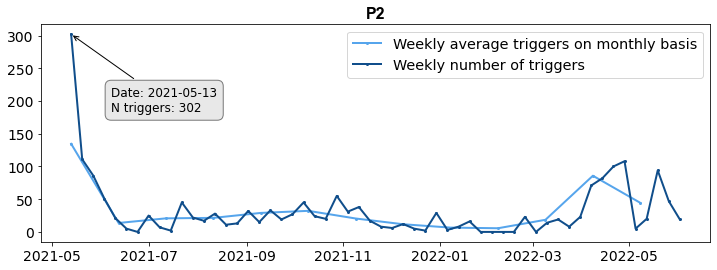

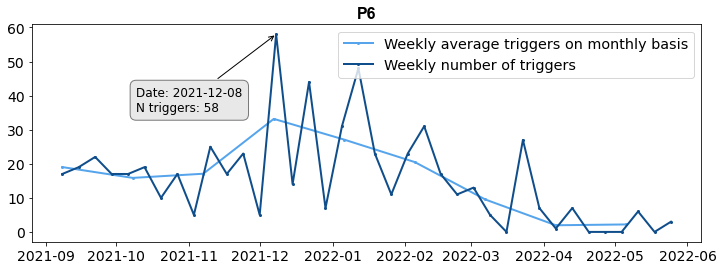

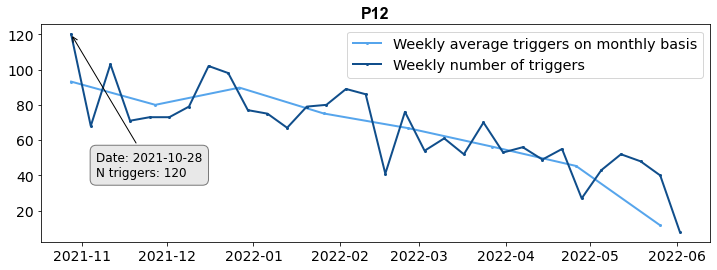

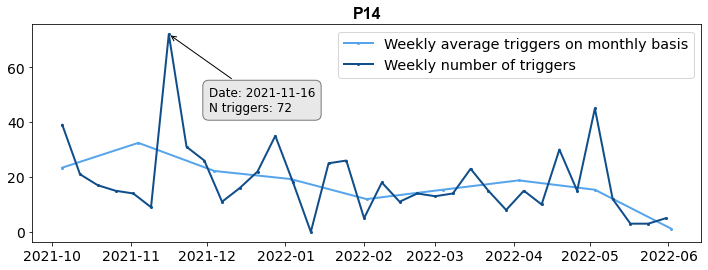

In [4]:
df_all = ale.get_usage_all(df_alexa)
df_all =df_all.drop(df_all.index[df_all.patient_id == 'P12'][:3]) 
nov.plot_usage_average_weekly(df_all, pid='P2', xy=(40, -80))
nov.plot_usage_average_weekly(df_all, pid='P6', xy=(-140, -80))
nov.plot_usage_average_weekly(df_all, pid='P12', xy=(25, -145))
nov.plot_usage_average_weekly(df_all, pid='P14', xy=(40, -80))

### Novelty effect stats

##### 1) All Alexa interactions (type questionnaire + random)

In [10]:
df_all = ale.get_usage_all(df_alexa)
df_all =df_all.drop(df_all.index[df_all.patient_id == 'P12'][:3]) 
# select users with total usage >3 months
users = [x for x in df_all.patient_id.unique() if x not in ['P8', 'P9', 'P11']]
array_difs = []
d1 = []
d2 = []
print('(weekly average of the 3 months novelty period' + ', weekly average of the post-novelty period' + ', total months)')
for pid in users:
    a= nov.novelty_effect(df=df_all, pid=pid)
    dif = a[2] - a[1]
    array_difs.append(dif)
    dist1 = a[1]
    dist2 = a[2]
    d1.append(dist1)
    d2.append(dist2)
stat_all, pvalue_all = wilcoxon(d1, d2)
wilcoxon(d1, d2)

(weekly average of the 3 months novelty period, weekly average of the post-novelty period, total months)


/Users/mr3418/opt/anaconda3/envs/minder_env/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=5.0, pvalue=0.02182427562605354)

In [12]:
x = np.array(d1)
y = np.array(d2)
pg.wilcoxon(x, y, alternative='two-sided')

/Users/mr3418/opt/anaconda3/envs/minder_env/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,5.0,two-sided,0.024932,0.818182,0.657025


##### 2) Triggers of questionnaire (type questionnaire)

In [13]:
df_questionnaire = df_all[df_all.int_type == 'questionnaire']
# select users with total usage >3 months
users = [x for x in df_all.patient_id.unique() if x not in ['P8', 'P9', 'P11']]
array_difs = []
d1 = []
d2 = []
print('(weekly average of the 3 months novelty period' + ', weekly average of the post-novelty period' + ', total months)')
for pid in users:
    a= nov.novelty_effect(df=df_questionnaire, pid=pid)
    dif = a[2] - a[1]
    array_difs.append(dif)
    dist1 = a[1]
    dist2 = a[2]
    d1.append(dist1)
    d2.append(dist2)
stat_quest, pvalue_quest = wilcoxon(d1,d2)
wilcoxon(d1,d2)

(weekly average of the 3 months novelty period, weekly average of the post-novelty period, total months)


WilcoxonResult(statistic=0.0, pvalue=0.0009765625)

In [14]:
x = np.array(d1)
y = np.array(d2)
pg.wilcoxon(x, y, alternative='two-sided')

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,0.0,two-sided,0.000977,1.0,0.719008


##### 3) Topics (type random) 

Note this result was not used in the paper.

In [6]:
df_topics_ = ale.get_usage_topics(df_topics)
df_topics_.topic.unique()

# select users with total usage >3 months
users = [x for x in df_all.patient_id.unique() if x not in ['P8', 'P9', 'P11']]
array_difs = []
d1 = []
d2 = []
print('(weekly average of the 3 months novelty period' + ', weekly average of the post-novelty period' + ', total months)')
for pid in users:
    a= nov.novelty_effect(df=df_topics_, pid=pid)
    dif = a[2] - a[1]
    array_difs.append(dif)
    dist1 = a[1]
    dist2 = a[2]
    d1.append(dist1)
    d2.append(dist2)
print('---> no statistical significante found')
wilcoxon(d1, d2)

(weekly average of the 3 months novelty period, weekly average of the post-novelty period, total months)
---> no statistical significante found


WilcoxonResult(statistic=14.0, pvalue=0.1015625)

##### FDR correction for 2 tests:

In [9]:
pvals = [pvalue_all, pvalue_quest]
# using FDR method: false discovery rate
multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

(array([ True,  True]),
 array([0.02182428, 0.00195312]),
 0.025320565519103666,
 0.025)